In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# import basic plot tools
from qiskit_textbook.tools import simon_oracle

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Simon's Problem

We are given an unknown blackbox function f , which is guaranteed to be either one-to-one ( 1 : 1 ) or two-to-one ( 2 : 1 ), where one-to-one and two-to-one functions have the following properties:
- one-to-one: maps exactly one unique output for every input. An example with a function that takes 4 inputs is:

$$f(1) \rightarrow 1, \quad f(2) \rightarrow 2, \quad f(3) \rightarrow 3, \quad f(4) \rightarrow 4$$

- two-to-one: maps exactly two inputs to every unique output. An example with a function that takes 4 inputs is:

$$f(1) \rightarrow 1, \quad f(2) \rightarrow 2, \quad f(3) \rightarrow 1, \quad f(4) \rightarrow 2$$

This two-to-one mapping is according to a hidden bitstring, b , where:

$$\textrm{given }x_1,x_2: \quad f(x_1) = f(x_2) \\
\textrm{it is guaranteed }: \quad x_1 \oplus x_2 = b$$

Given this blackbox f , how quickly can we determine if f is one-to-one or two-to-one? Then, if f turns out to be two-to-one, how quickly can we determine b ? As it turns out, both cases boil down to the same problem of finding b , where a bitstring of b = 000... represents the one-to-one f .

## Simon's Algorithm

### Classlical Solution

Classically, if we want to know what b is with 100% certainty for a given f , we have to check up to $2^{n−1}+1$ inputs, where n is the number of bits in the input. This means checking just over half of all the possible inputs until we find two cases of the same output. If we get lucky, we could solve the problem with our first two tries. But if we happen to get an f that is one-to-one, or get really unlucky with an f that’s two-to-one, then we’re stuck with the full $2^{n−1}+1$. There are known algorithms that have a lower bound of $\Omega(2^{n/2})$, but generally speaking the complexity grows exponentially with n.

### Quantum Solution

A query function, $\text{Q}_f$ acts on two quantum registers as:

$$\lvert x \rangle \lvert a \rangle \rightarrow \lvert x \rangle \lvert a \oplus f(x) \rangle$$

In the specific case that the second register is in the state $|0\rangle = |00\dots0\rangle$ we have:

$$\lvert x \rangle \lvert 0 \rangle \rightarrow \lvert x \rangle \lvert f(x) \rangle$$

The algorithm involves the following steps.

1- Two n -qubit input registers are initialized to the zero state.

$$\lvert \psi_1 \rangle = \lvert 0 \rangle^{\otimes n} \lvert 0 \rangle^{\otimes n}$$

2- Apply a Hadamard transform to the first register:

$$\lvert \psi_2 \rangle = (H^{\otimes n} \lvert 0 \rangle^{\otimes n}) \lvert 0 \rangle^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^{n} } \lvert x \rangle\lvert 0 \rangle^{\otimes n}$$

3- Apply the query function $\text{Q}_f$: 

$$\lvert \psi_3 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^{n} } \lvert x \rangle \lvert f(x) \rangle$$

4- Measure the second register. A certain value of f ( x ) will be observed. Because of the setting of the problem, the observed value f ( x ) could correspond to two possible inputs: x and y = x ⊕ b . Therefore the first register becomes:

$$\lvert \psi_4 \rangle = \frac{1}{\sqrt{2}}  \left( \lvert x \rangle + \lvert y \rangle \right)$$

where we omitted the second register since it has been measured.

5- Apply Hadamard on the first register:

$$\lvert \psi_5 \rangle = \frac{1}{\sqrt{2^{n+1}}} \sum_{z \in \{0,1\}^{n} } \left[  (-1)^{x \cdot z} + (-1)^{y \cdot z} \right]  \lvert z \rangle$$

6- Measuring the first register will give an output only if:

$$(-1)^{x \cdot z} = (-1)^{y \cdot z}$$

which means:

$$x \cdot z = y \cdot z \\
     x \cdot z = \left( x \oplus b \right) \cdot z \\
     x \cdot z = x \cdot z \oplus b \cdot z \\
     b \cdot z = 0 \text{ (mod 2)}
$$

A string z will be measured, whose inner product with b = 0. Thus, repeating the algorithm ≈ n times, we will be able to obtain n different values of z and the following system of equation can be written:

$$\begin{cases} b \cdot z_1 = 0 \\ b \cdot z_2 = 0 \\ \quad \vdots \\ b \cdot z_n = 0 \end{cases}$$

From which b can be determined, for example by Gaussian elimination.

So, in this particular problem the quantum algorithm performs exponentially fewer steps than the classical one. Once again, it might be difficult to envision an application of this algorithm (although it inspired the most famous algorithm created by Shor) but it represents the first proof that there can be an exponential speed-up in solving a specific problem by using a quantum computer rather than a classical one.

### Simon's Algorithm for 2 Qubits

Let's see the example of Simon's algorithm for 2 qubits with the secret string b = 11 , so that f ( x ) = f ( y ) if y = x ⊕ b .

1- Two 2 -qubit input registers are initialized to the zero state:

$$\lvert \psi_1 \rangle = \lvert 0 0 \rangle_1 \lvert 0 0 \rangle_2$$

2- Apply Hadamard gates to the qubits in the first register:

$$\lvert \psi_2 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle_1 + \lvert 0 1 \rangle_1 + \lvert 1 0 \rangle_1 + \lvert 1 1 \rangle_1 \right) \lvert 0 0 \rangle_2$$

3- For the string b = 11 , the query function can be implemented as $\text{Q}_f = CX_{1_a 2_a}CX_{1_a 2_b}CX_{1_b 2_a}CX_{1_b 2_b}$:

$$\begin{aligned}
\lvert \psi_3 \rangle  = \frac{1}{2} ( \; 
  & \lvert 0 0 \rangle_1 \; \lvert 0\oplus 0 \oplus 0, & 0 \oplus 0 \oplus 0 \rangle_2 &\\[5pt]
+ & \lvert 0 1 \rangle_1 \; \lvert 0\oplus 0 \oplus 1, & 0 \oplus 0 \oplus 1 \rangle_2 &\\[6pt]
+ & \lvert 1 0 \rangle_1 \; \lvert 0\oplus 1 \oplus 0, & 0 \oplus 1 \oplus 0 \rangle_2 &\\[6pt]
+ & \lvert 1 1 \rangle_1 \; \lvert 0\oplus 1 \oplus 1, & 0 \oplus 1 \oplus 1 \rangle_2 & \; )\\
\end{aligned}$$

Thus:

$$\begin{aligned} 
\lvert \psi_3 \rangle = \frac{1}{2} (
 \lvert 0 0 \rangle_1  \lvert 0 0 \rangle_2 
+  \lvert 0 1 \rangle_1 \lvert 1  1 \rangle_2 
+  \lvert 1 0 \rangle_1 \lvert  1   1  \rangle_2 
+  \lvert 1 1 \rangle_1 \lvert 0 0 \rangle_2 & \;)
\end{aligned}
$$


4- We measure the second register. With 50 % probability we will see either $\lvert  0   0  \rangle_2$ or $\lvert  1   1  \rangle_2$ . For the sake of the example, let us assume that we see $\lvert  1   1  \rangle_2$ . The state of the system is then:

$$\lvert \psi_4 \rangle = \frac{1}{\sqrt{2}}  \left( \lvert  0   1  \rangle_1 + \lvert  1   0  \rangle_1 \right)$$

where we omitted the second register since it has been measured.

5- Apply Hadamard on the first register

$$\lvert \psi_5 \rangle = \frac{1}{2\sqrt{2}} \left[ \left( \lvert 0 \rangle + \lvert 1 \rangle \right) \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right) + \left( \lvert 0 \rangle - \lvert 1 \rangle \right) \otimes \left( \lvert 0 \rangle + \lvert 1 \rangle \right)  \right] \\
    =  \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle - \lvert 0 1 \rangle + \lvert 1 0 \rangle - \lvert 1 1 \rangle   + \lvert 0 0 \rangle + \lvert 0 1 \rangle - \lvert 1 0 \rangle - \lvert 1 1 \rangle \right] \\
    = \frac{1}{\sqrt{2}} \left( \lvert 0 0 \rangle - \lvert 1 1 \rangle \right)$$

6- Measuring the first register will give either |00⟩ or |11⟩ with equal probability.

7- If we see |11⟩, then:

$$b \cdot 11 = 0$$

which tells us that b ≠ 01 or 10 , and the two remaining potential solutions are b = 00 or b = 11 . Note that b = 00 will always be a trivial solution to our simultaneous equations. If we repeat steps 1-6 many times, we would only measure |00⟩ or |11⟩ as

$$b \cdot 11 = 0 \\ b \cdot 00 = 0$$


are the only equations that satisfy b = 11 . We can verify b = 11 by picking a random input ($x_i$) and checking $f ( x_i ) = f ( x_i \oplus b )$ . For example:

$$01 \oplus b = 10$$
$$f(01) = f(10) = 11$$

### Now we will apply Simon's algorithm in Qiskit using 3 qubits and b = 110.

/tmp/ipykernel_59/1447397014.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  simon_circuit += simon_oracle(b)


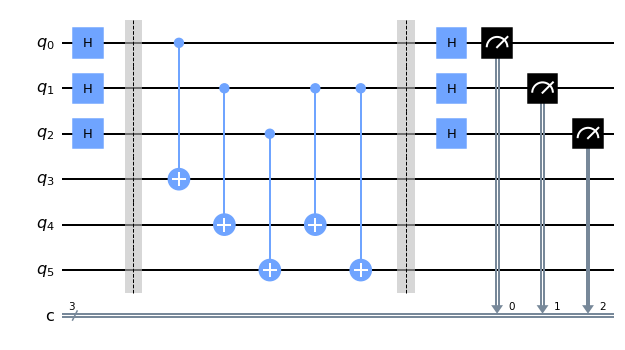

In [2]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit += simon_oracle(b)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

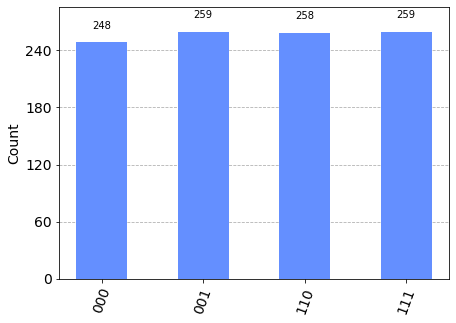

In [3]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [4]:
#Since we know b already, we can verify these results do satisfy b ⋅ z = 0 ( mod 2 )
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

110.110 = 0 (mod 2)
110.001 = 0 (mod 2)
110.111 = 0 (mod 2)
110.000 = 0 (mod 2)


Using these results, we can recover the value of b = 110 by solving this set of simultaneous equations. For example, say we first measured 001, this tells us:

$$\require{cancel}
\begin{aligned}
b \cdot 001 &= 0 \\
(b_2 \cdot 0) + (b_1 \cdot 0) + (b_0 \cdot 1) & = 0 \\
(\cancel{b_2 \cdot 0}) + (\cancel{b_1 \cdot 0}) + (b_0 \cdot 1) & = 0 \\
b_0 & = 0\\
\end{aligned}
$$

If we next measured 111, we have:

$$\require{cancel}
\begin{aligned}
b \cdot 111 &= 0 \\
(b_2 \cdot 1) + (b_1 \cdot 1) + (\cancel{0 \cdot 1}) & = 0 \\
(b_2 \cdot 1) + (b_1 \cdot 1) & = 0 \\
\end{aligned}
$$

Which tells us either:

$$b_2 = b_1 = 0, \quad b = 000$$

or

$$b_2 = b_1 = 1, \quad b = 110$$

Of which b = 110 is the non-trivial solution to our simultaneous equations. We can solve these problems in general using Gaussian elimination, which has a run time of $O(n^3)$ .